In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


In [4]:
from sklearn.metrics import confusion_matrix

def confusion(y_val, y_pred):
    # Assuming y_val and y_pred are defined
    cm = confusion_matrix(y_val, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [38]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


len_train: 140700
len_test: 93800
len_X: 234500


In [43]:
def preprocess_all_data(train, test, split=False):


    X_train = train.drop('Depression', axis=1)
    y_train = train['Depression']
    X = pd.concat([X_train, test], axis=0)
    len_train = len(X_train)
    len_test = len(test)
    len_X = len(X)
    print('len_train:', len_train)
    print('len_test:', len_test)
    print('len_X:', len_X)


    if split:




        X = X.drop(['id', 'Name'], axis=1)
        X['Pressure'] = X[['Work Pressure', 'Academic Pressure']].max(axis=1)
        X = X.drop(['Work Pressure', 'Academic Pressure'], axis=1)
        X['Gender'] = (X['Gender'] == 'Male').astype(int)
        X.loc[X['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        X = X.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
        X['Family History of Mental Illness'] = (X['Family History of Mental Illness'] == 'Yes').astype(int)
        X['Have you ever had suicidal thoughts ?'] = (X['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)


        X = X.drop(['City'], axis=1)


        # v = X["City"].value_counts() 
        # tmp = X[X['City'].isin(v.index[v.gt(10)])]
        # tmp = pd.get_dummies(tmp, columns=['City'])
        # tmp_cols = [col for col in tmp.columns if col.startswith('City_')]
        # X = pd.get_dummies(X, columns=['City'])
        # City_cols = [col for col in X.columns if col.startswith('City_')]
        # X[City_cols] = X[City_cols].astype(int)
        # X = X.drop(tmp_cols, axis=1)



        diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_mapping)
        v = X["Profession"].value_counts() 

        X = pd.get_dummies(X, columns=['Profession'])
        profession_cols = [col for col in X.columns if col.startswith('Profession_')]
        X[profession_cols] = X[profession_cols].astype(int)
        X = X.drop(['Working Professional or Student'], axis=1)
        v = X["Degree"].value_counts() 
        X = pd.get_dummies(X, columns=['Degree'])
        degree_cols = [col for col in X.columns if col.startswith('Degree_')]
        X[degree_cols] = X[degree_cols].astype(int)
        dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
        X['Sleep Duration'] = X['Sleep Duration'].map(dict_sleep)
        X['CGPA'] = X['CGPA'].fillna(X['CGPA'].mean())

        XS = X[X['Profession_Student'] == 1]
        XP = X[X['Profession_Student'] == 0]
        XP = XP.drop(['Profession_Student'], axis=1)
        XS = XS.drop(['Profession_Student'], axis=1)
        XP = XP.drop(['CGPA'], axis=1)


        return XS, XP



    else :
        X = X.drop(['id', 'Name'], axis=1)
        X['Pressure'] = X[['Work Pressure', 'Academic Pressure']].max(axis=1)
        X = X.drop(['Work Pressure', 'Academic Pressure'], axis=1)
        X['Gender'] = (X['Gender'] == 'Male').astype(int)
        X.loc[X['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        X = X.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
        X['Family History of Mental Illness'] = (X['Family History of Mental Illness'] == 'Yes').astype(int)
        X['Have you ever had suicidal thoughts ?'] = (X['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)


        X = X.drop(['City'], axis=1)


        # v = X["City"].value_counts() 
        # tmp = X[X['City'].isin(v.index[v.gt(10)])]
        # tmp = pd.get_dummies(tmp, columns=['City'])
        # tmp_cols = [col for col in tmp.columns if col.startswith('City_')]
        # X = pd.get_dummies(X, columns=['City'])
        # City_cols = [col for col in X.columns if col.startswith('City_')]
        # X[City_cols] = X[City_cols].astype(int)
        # X = X.drop(tmp_cols, axis=1)



        diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_mapping)
        v = X["Profession"].value_counts() 

        X = pd.get_dummies(X, columns=['Profession'])
        profession_cols = [col for col in X.columns if col.startswith('Profession_')]
        X[profession_cols] = X[profession_cols].astype(int)
        X = X.drop(['Working Professional or Student'], axis=1)
        v = X["Degree"].value_counts() 
        X = pd.get_dummies(X, columns=['Degree'])
        degree_cols = [col for col in X.columns if col.startswith('Degree_')]
        X[degree_cols] = X[degree_cols].astype(int)
        dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
        X['Sleep Duration'] = X['Sleep Duration'].map(dict_sleep)
        X['CGPA'] = X['CGPA'].fillna(X['CGPA'].mean())


        return X
Xs, Xp = preprocess_all_data(train, test, split=True)  


len_train: 140700
len_test: 93800
len_X: 234500


In [8]:
X_train = X[:len_train]
X_test = X[len_train:]
print('X_train:', len(X_train))
print('X_test:', len(X_test))

X_train: 140700
X_test: 93800


In [9]:
train = pd.concat([X_train, y_train], axis=1)
train = train.dropna()
X_train = train.drop('Depression', axis=1)
y_train = train['Depression']
from sklearn.model_selection import train_test_split
split = 0.2
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=split, random_state=42)

In [58]:
def preprocess_data(train):
    train.loc[train['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
    train['Satisfaction'] = train[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
    train = train.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
    train['Family History of Mental Illness'] = (train['Family History of Mental Illness'] == 'Yes').astype(int)
    train['Have you ever had suicidal thoughts ?'] = (train['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)
    # we can either drop City or encode it in one hot encoding
    # one hot encoding
    #train = pd.get_dummies(train, columns=['City']).astype(int)
    # drop city



    train = train.drop(['City'], axis=1)



    # v = train["City"].value_counts() 
    # train = train[train['City'].isin(v.index[v.gt(10)])]
    # train = pd.get_dummies(train, columns=['City'])
    # City_cols = [col for col in train.columns if col.startswith('City_')]
    # train[City_cols] = train[City_cols].astype(int)



    diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
    train = train[train['Dietary Habits'].isin(diet_mapping.keys())]
    train['Dietary Habits'] = train['Dietary Habits'].map(diet_mapping)
    v = train["Profession"].value_counts() 
    # keep only the profession with more than 10 samples
    train = train[train['Profession'].isin(v.index[v.gt(10)])]
    # one hot encoding
    train = pd.get_dummies(train, columns=['Profession'])
    profession_cols = [col for col in train.columns if col.startswith('Profession_')]
    train[profession_cols] = train[profession_cols].astype(int)
    train = train.drop(['Working Professional or Student'], axis=1)
    v = train["Degree"].value_counts() 
    train = train[train['Degree'].isin(v.index[v.gt(10)])]
    # one hot encoding
    train = pd.get_dummies(train, columns=['Degree'])
    degree_cols = [col for col in train.columns if col.startswith('Degree_')]
    train[degree_cols] = train[degree_cols].astype(int)
    dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
    train = train[train['Sleep Duration'].isin(dict_sleep.keys())]
    train['Sleep Duration'] = train['Sleep Duration'].map(dict_sleep)
    train['CGPA'] = train['CGPA'].fillna(train['CGPA'].mean())
    train = train.dropna()
    return train
# train.to_csv('train_cleaned.csv', index=False)

In [55]:
# Baseline model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score



In [56]:
# import the train test split


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.ensemble import StackingClassifier

# Logistic Regression
lr = LogisticRegression(C=1, max_iter=100, penalty ='l1', solver = 'liblinear')
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split= 4, subsample= 1.0, random_state=42)

estimators = [('lr', lr), ('gb', gb)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train2, y_train2)
y_pred = stack.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.9383357041251779


In [27]:
from sklearn.ensemble import VotingClassifier
vote = VotingClassifier(estimators=estimators, voting='soft')
vote.fit(X_train2, y_train2)
y_pred = vote.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.9381578947368421


0:	learn: 0.5353719	total: 8.34ms	remaining: 1.66s
100:	learn: 0.1496430	total: 833ms	remaining: 817ms
199:	learn: 0.1457654	total: 1.68s	remaining: 0us
Accuracy: 0.938620199146515


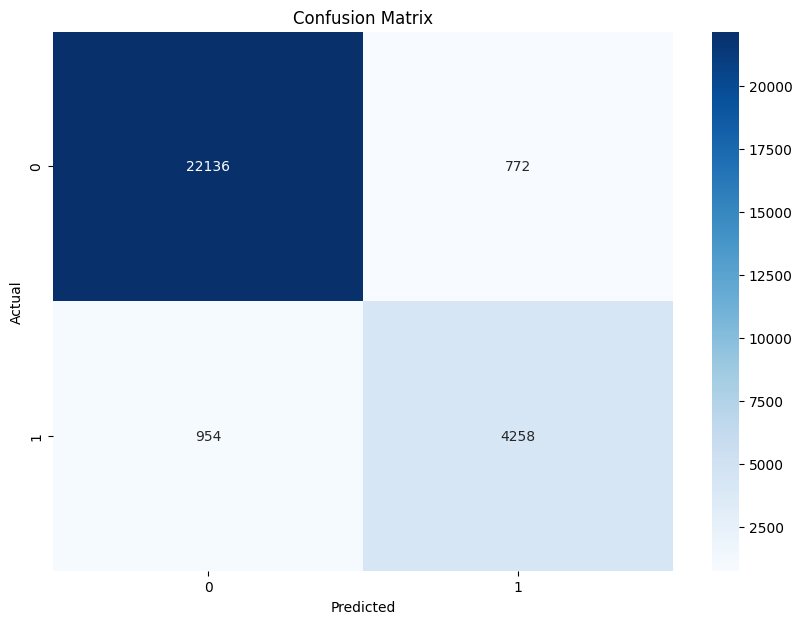

In [36]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Define the CatBoost classifier
catboost = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1, loss_function='Logloss', verbose=100, l2_leaf_reg= 1)

# Fit the model
catboost.fit(X_train2, y_train2)
y_pred = catboost.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))
# Confusion Matrix
confusion(y_val, y_pred)

In [47]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the LightGBM classifier
lgbm = LGBMClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.01],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [-1, 10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Score:', best_score)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183[LightGBM] [Info] Start training from score -1.507183

[LightGBM] [Info] Start training from score -1.507183
[LightGBM] [Info

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'objective': 'binary'}
Best Score: 0.8733475479744136
Validation Accuracy: 0.8724946695095949


In [48]:
lgbm = LGBMClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.1],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [-1, 10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Score:', best_score)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183
[LightGBM] [Info] Number of positive: 13608, number of negative: 61432
[LightGBM] [Info] Start training from score -1.507183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGB

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'objective': 'binary'}
Best Score: 0.8781538734896944
Validation Accuracy: 0.8785714285714286


In [49]:
lgbm = LGBMClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.3],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['binary'],
    'max_depth': [-1, 10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best Parameters:', best_params)
print('Best Score:', best_score)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181357 -> initscore=-1.507183
[LightGBM] [Info] Start training from score -1.507183
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Number of positive: 13608, number of negative: 61432
[LightGBM] [Info] Number of positive: 13609, number of negative: 61431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 75040, number of used features: 2
[LightGB

/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 50, 'objective': 'binary'}
Best Score: 0.8781982942430705
Validation Accuracy: 0.8787135749822317


In [2]:
from sklearn.model_selection import train_test_split
split = 0.2
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=split, random_state=42)

NameError: name 'X_train' is not defined

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the XGBoost classifier
xgb = XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'objective': ['binary:logistic']
}


# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_

print('Best Parameters:', best_params)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

Best Parameters: {'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.7}
Validation Accuracy: 0.9383357041251779


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=1, n_neurons=30, learning_rate=3e-3, epochs=10, batch_size=32):
        self.n_hidden = n_hidden
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    
    def create_model(self, input_shape):
        model = Sequential()
        model.add(Dense(self.n_neurons, activation='relu', input_shape=input_shape))
        
        for _ in range(self.n_hidden):
            model.add(Dense(self.n_neurons, activation='relu'))
            
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        # Create new model instance for each fit
        self.model = self.create_model(input_shape=[X.shape[1]])
        
        # Reshape y if needed
        y = np.array(y)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        # Fit the model
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X, verbose=0)
        return (predictions > 0.5).astype(int).ravel()
    
    def predict_proba(self, X):
        predictions = self.model.predict(X, verbose=0)
        return np.hstack([1 - predictions, predictions])

# Create model instance
model = KerasClassifierWrapper()

# Define the parameter grid
grid_params = {
    'n_hidden': [1, 2, 3],
    'n_neurons': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)



# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_

print('Best Parameters:', best_params)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

2024-11-22 10:37:50.289083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:37:50.305820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:37:50.307371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 10:37:50.315537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732268270.315366   31137 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

Best Parameters: {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.01, 'n_hidden': 1, 'n_neurons': 10}
Validation Accuracy: 0.9365220483641536


In [48]:
# in X_test replace the nan values with the median of the column
X_test = X_test.fillna(X_test.median())

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# import gradient boosting and xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# Define the model creation function
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=input_shape))
    for _ in range(1):
        model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

input_shape = [X_train2.shape[1]]
model = create_model(input_shape)

# Train the model
history = model.fit(X_train2, y_train2, epochs=10, batch_size=10, validation_split=0.2)

# XGBoost Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
xgb = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')

# Best Gradient Boosting parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
gb = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_split=4, n_estimators=200, subsample=1.0)


# Stacking Classifier tensor flow, xgboost, gradient boosting

estimators = [('model', model), ('xgb', xgb), ('gb', gb)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train2, y_train2)
y_pred = stack.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

Epoch 1/10


/home/karim/miniconda3/envs/T1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8999/8999 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9263 - loss: 0.1830

KeyboardInterrupt: 

In [29]:
# Oversampling the train data
from imblearn.over_sampling import SMOTE

# Define the oversampling strategy
oversample = SMOTE()

# Fit and apply the transform
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train2, y_train2)

gb = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_split=4, n_estimators=200, subsample=1.0)


# Train the model
history = gb.fit(X_train_resampled, y_train_resampled)

# Predict the validation set
y_pred = gb.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))


Validation Accuracy: 0.936877667140825


In [22]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming X_val and y_val are your validation data
# Get the predicted probabilities
y_pred_prob = model.predict(X_val)

# Define a range of thresholds to evaluate
thresholds = np.arange(0.0, 1.0, 0.01)

# Initialize variables to store the best threshold and best F1 score
best_threshold = 0.0
best_f1 = 0.0

# Evaluate F1 score at each threshold
for threshold in thresholds:
    y_pred = (y_pred_prob > threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')

# Use the best threshold to make final predictions
y_pred_final = (y_pred_prob > best_threshold).astype(int)
print(y_pred_final)

879/879 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step
Best Threshold: 0.42
Best F1 Score: 0.8310083325531318
[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [44]:
# Best Gradient Boosting parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split= 4, subsample= 1.0, random_state=42)

gb.fit(X_train2, y_train2)
y_pred = gb.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.8919331911869225


In [24]:
def prediction_finale(model, X_train, y_train, X_test, threshold=0.5):
    X_test = X_test.fillna(X_test.median())
    model.fit(X_train, y_train)
    sub = model.predict(X_test)
    sub = (sub > threshold).astype(int)
    submissions = pd.DataFrame(data=sub, columns=['Depression'])
    submissions['id'] = test['id']
    submissions = submissions[['id', 'Depression']]
    submissions.to_csv('submission.csv', index=False)

In [25]:
prediction_finale(model, X_train, y_train, X_test, 0.42)

 166/4394 ━━━━━━━━━━━━━━━━━━━━ 3s 943us/step - accuracy: 0.9298 - loss: 0.1657

2024-11-22 16:30:08.596896: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138348432 exceeds 10% of free system memory.


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9368 - loss: 0.1571
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step


In [ ]:
# todo : oversampling
# todo : split student and professional
# todo : faire un tableau avec/sans PCA